In [1]:
!pip install xgboost networkx

# SCM DAG Generation

In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import warnings

# --- Helper functions for sampling from distributions ---

def sample_log_uniform(low, high, size=1, base=np.e):
    return np.power(base, np.random.uniform(np.log(low)/np.log(base), np.log(high)/np.log(base), size))

def sample_discretized_log_normal(mean, min_val, size=1):
    sigma = 0.8
    val = np.random.lognormal(mean=np.log(mean), sigma=sigma, size=size)
    return np.maximum(min_val, np.round(val)).astype(int)

def sample_exponential(scale, min_val, size=1):
    return min_val + np.round(np.random.exponential(scale=scale, size=size)).astype(int)

def generate_mlp_dropout_dag(num_nodes: int, num_layers: int, edge_dropout_prob: float = 0.2) -> nx.DiGraph:
    G = nx.DiGraph()
    nodes_per_layer_base = np.zeros(num_layers, dtype=int) + 1
    nodes_remaining = num_nodes - num_layers
    if nodes_remaining > 0:
        splits = np.sort(np.random.choice(nodes_remaining + num_layers - 1, num_layers - 1, replace=False))
        layer_sizes = np.diff(np.concatenate(([0], splits, [nodes_remaining + num_layers - 1]))) - 1
        nodes_per_layer_base += layer_sizes
    node_indices = np.arange(num_nodes)
    nodes_per_layer = np.split(node_indices, np.cumsum(nodes_per_layer_base)[:-1])
    for i, layer_nodes in enumerate(nodes_per_layer):
        for node in layer_nodes:
            G.add_node(node, layer=i)
    for i in range(num_layers - 1):
        for u in nodes_per_layer[i]:
            for v in nodes_per_layer[i+1]:
                if np.random.rand() > edge_dropout_prob:
                    G.add_edge(u, v)
    return G

def generate_scale_free_dag(num_nodes: int, m_edges: int = 2) -> nx.DiGraph:
    undirected_G = nx.barabasi_albert_graph(n=num_nodes, m=m_edges)
    G = nx.DiGraph()
    G.add_nodes_from(undirected_G.nodes())
    for u, v in undirected_G.edges():
        if u < v: G.add_edge(u, v)
        else: G.add_edge(v, u)
    for node in G.nodes():
        G.nodes[node]['layer'] = node % 5
    return G

def sample_dag_structure(config: dict) -> nx.DiGraph:
    graph_type = np.random.choice(config['graph_generation_method'])
    num_nodes = int(sample_log_uniform(config['num_nodes_low'], config['num_nodes_high'])[0])
    print(f"Generating a '{graph_type}' graph with {num_nodes} nodes...")
    if graph_type == 'MLP-Dropout':
        num_layers = sample_discretized_log_normal(mean=config['mlp_num_layers_mean'], min_val=2)[0]
        return generate_mlp_dropout_dag(num_nodes=num_nodes, num_layers=num_layers)
    elif graph_type == 'Scale-Free':
        m_edges = np.random.randint(1, 5)
        return generate_scale_free_dag(num_nodes=num_nodes, m_edges=m_edges)



def softplus(x):
    return np.maximum(0, x) + np.log(1 + np.exp(-np.abs(x)))

SELU_LAMBDA = 1.0507
SELU_ALPHA = 1.67326

# Expanded dictionary of activation functions from the TabICL paper
ACTIVATION_FUNCTIONS = {
    'identity': lambda x: x,
    'tanh': np.tanh,
    'leaky_relu': lambda x: np.maximum(0.01 * x, x),
    'elu': lambda x: np.where(x > 0, x, 0.5 * (np.exp(x) - 1)),
    'silu': lambda x: x / (1 + np.exp(-x)),
    'sine': np.sin,
    'relu': lambda x: np.maximum(0, x),
    'relu6': lambda x: np.minimum(np.maximum(0, x), 6),
    'selu': lambda x: SELU_LAMBDA * np.where(x > 0, x, SELU_ALPHA * (np.exp(x) - 1)),
    'softplus': softplus,
    'hardtanh': lambda x: np.maximum(-1, np.minimum(1, x)),
    'sign': np.sign,
    'rbf': lambda x: np.exp(-np.square(x)),
    'exp': lambda x: np.exp(np.clip(x, -10, 10)), # Clipped for stability
    'sqrt_abs': lambda x: np.sqrt(np.abs(x)),
    'indicator_abs_le_1': lambda x: np.where(np.abs(x) <= 1, 1, 0),
    'square': np.square,
    'absolute': np.abs,
}

class RandomFourierFeatureFunction:
    """
    Implements the random function mechanism using Random Fourier Features. Internal parameters are sampled once upon initialization.
    """
    def __init__(self, N=256):
        # Sample parameters for the feature map phi once per instance of this class
        self.N = N
        u = np.random.uniform(0.7, 3.0)
        self.b = np.random.uniform(0, 2 * np.pi, N)
        self.a = np.random.uniform(0, N, N)
        # This weighting leads to different levels of smoothness
        self.w = self.a ** (-np.exp(u))

    def __call__(self, x: np.ndarray) -> np.ndarray:
        # x is a 1D array of input values
        # The random vector z is sampled for each call
        z = np.random.randn(self.N)

        # Ensure x is 2D for broadcasting
        if x.ndim == 1:
            x = x[:, np.newaxis]

        # phi(x) = (w / ||w||_2) * sin(ax + b)
        phi_x = (self.w / np.linalg.norm(self.w)) * np.sin(self.a * x + self.b)

        # f(x) = phi(x)^T z
        return np.dot(phi_x, z)

def assign_functional_mechanisms(dag: nx.DiGraph, config: dict):
    """
    Assigns a computational function to each node,
    """
    function_choices = config['scm_activation_functions'] + ['random_fourier']

    for node in dag.nodes():
        choice = np.random.choice(function_choices)

        # Determine if the node should be simple SCM, tree, or random fourier
        if choice != 'random_fourier' and np.random.rand() < config['function_type_mixture_ratio']:
            func_name = np.random.choice(config['scm_activation_functions'])
            parents = list(dag.predecessors(node))
            dag.nodes[node].update({
                'type': 'scm', 'function_name': func_name,
                'function': ACTIVATION_FUNCTIONS[func_name],
                'weights': np.random.randn(len(parents)), 'bias': np.random.randn()
            })
        elif choice == 'random_fourier':
            parents = list(dag.predecessors(node))
            dag.nodes[node].update({
                'type': 'random_fourier', 'function_name': 'RandomFourierFunc',
                'function': RandomFourierFeatureFunction(),
                # This function type operates on a single parent's output
                'parent_selector': np.random.randint(len(parents)) if parents else None
            })
        else: # Tree-based
            params = {
                'n_estimators': sample_exponential(config['xgb_n_estimators_exp_scale'], 1)[0],
                'max_depth': sample_exponential(config['xgb_max_depth_exp_scale'], 2)[0],
                'n_jobs': 1
            }
            model = xgb.XGBRegressor(**params)
            dag.nodes[node].update({
                'type': 'tree', 'function_name': 'XGBoost',
                'function': model, 'params': params
            })

Generating a 'MLP-Dropout' graph with 23 nodes...

Node 0:
  - Mechanism Type: scm
  - Function: exp
  - Number of Weights: 0
  - Bias value: -0.41

Node 1:
  - Mechanism Type: scm
  - Function: absolute
  - Number of Weights: 0
  - Bias value: 0.74

Node 2:
  - Mechanism Type: tree
  - Function: XGBoost
  - XGBoost Params: {'n_estimators': np.int64(2), 'max_depth': np.int64(2), 'n_jobs': 1}

Node 3:
  - Mechanism Type: tree
  - Function: XGBoost
  - XGBoost Params: {'n_estimators': np.int64(1), 'max_depth': np.int64(3), 'n_jobs': 1}

Node 4:
  - Mechanism Type: random_fourier
  - Function: RandomFourierFunc
  - Function Object: <__main__.RandomFourierFeatureFunction object at 0x7d29e94709d0>

Node 5:
  - Mechanism Type: scm
  - Function: identity
  - Number of Weights: 0
  - Bias value: -1.63

Node 6:
  - Mechanism Type: scm
  - Function: leaky_relu
  - Number of Weights: 0
  - Bias value: -0.56

Node 7:
  - Mechanism Type: scm
  - Function: absolute
  - Number of Weights: 0
  - Bias 

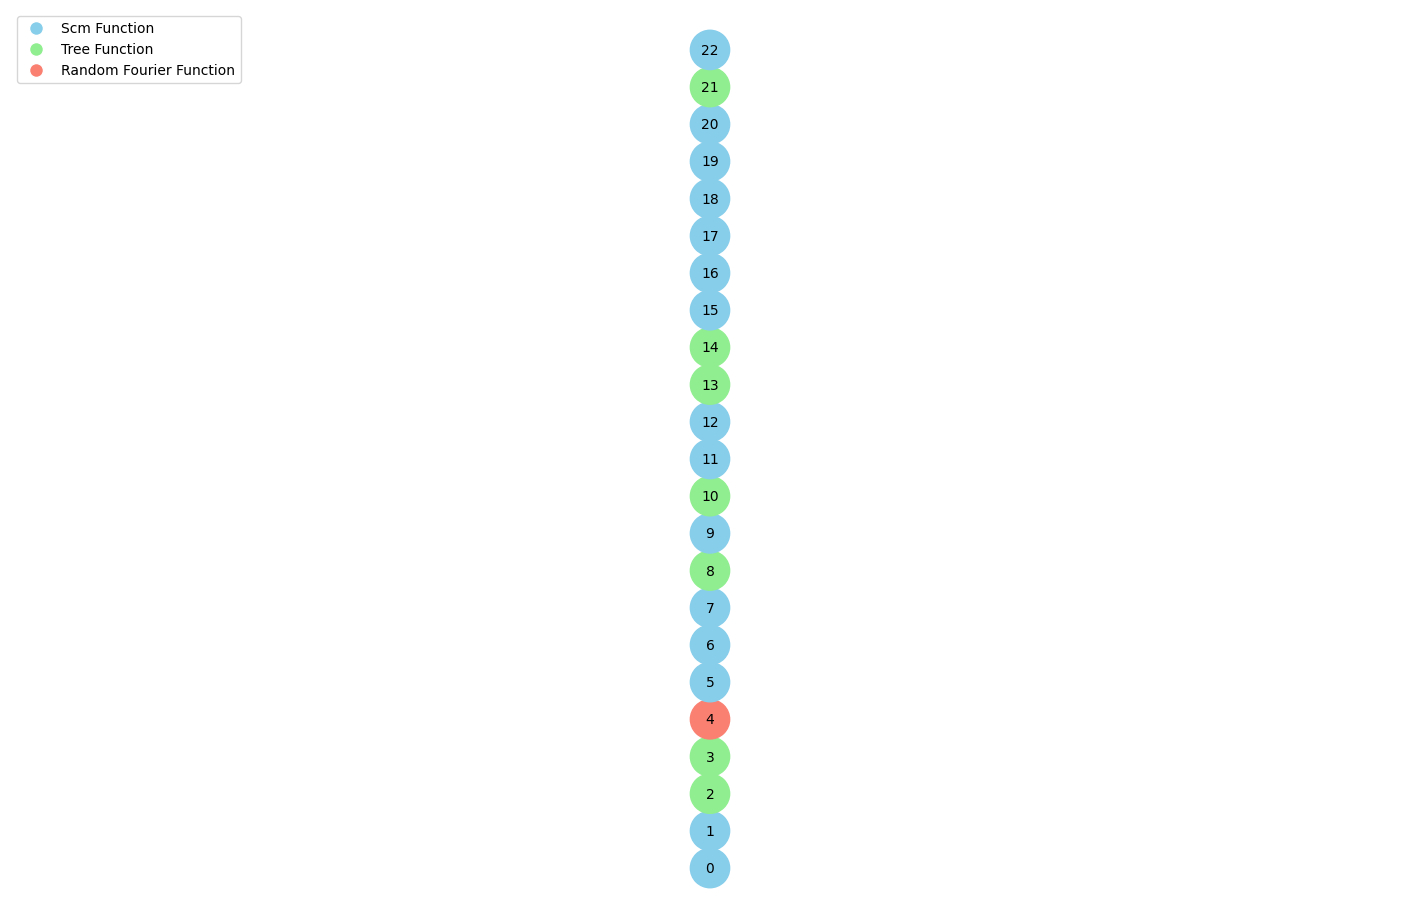

In [3]:
config = {
    'graph_generation_method': ['MLP-Dropout'],
    'num_nodes_low': 15,
    'num_nodes_high': 30,
    'mlp_num_layers_mean': 4,
    'function_type_mixture_ratio': 0.7, # 70% SCMs or Random Fourier, 30% Tree-based
    'scm_activation_functions': list(ACTIVATION_FUNCTIONS.keys()),
    'xgb_n_estimators_exp_scale': 0.5,
    'xgb_max_depth_exp_scale': 0.5,
}

# --- Generate a sample DAG ---
test_dag = sample_dag_structure(config)

# --- Run the updated function to assign mechanisms ---
assign_functional_mechanisms(test_dag, config)


# --- just verifying ---
for node_id, data in test_dag.nodes(data=True):
    mechanism_type = data.get('type')
    func_name = data.get('function_name')

    print(f"\nNode {node_id}:")
    print(f"  - Mechanism Type: {mechanism_type}")
    print(f"  - Function: {func_name}")

    if mechanism_type == 'scm':
        print(f"  - Number of Weights: {len(data.get('weights', []))}")
        print(f"  - Bias value: {data.get('bias', 'N/A'):.2f}")
    elif mechanism_type == 'tree':
        print(f"  - XGBoost Params: {data.get('params', {})}")
    elif mechanism_type == 'random_fourier':
        print(f"  - Function Object: {data.get('function')}")


# Check that a mix of mechanism types were assigned
types_assigned = {data.get('type') for _, data in test_dag.nodes(data=True)}
print(f"\nmechanism types assigned to graph: {types_assigned}")

# Visualize
plt.figure(figsize=(14, 9))
pos = nx.multipartite_layout(test_dag, subset_key='layer')

color_map = {'scm': 'skyblue', 'tree': 'lightgreen', 'random_fourier': 'salmon'}
colors = [color_map.get(data.get('type', 'scm')) for _, data in test_dag.nodes(data=True)]

nx.draw(test_dag, pos, with_labels=True, node_size=800, node_color=colors, font_size=10, arrows=True)

legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=f'{mech_type.replace("_", " ").title()} Function',
                             markerfacecolor=color, markersize=10) for mech_type, color in color_map.items()]
plt.legend(handles=legend_handles, loc='upper left')

plt.show()

Generating a 'Scale-Free' graph with 23 nodes...
Node 0: Type='scm', Function='silu'
Node 1: Type='scm', Function='sine'
Node 2: Type='tree', Function='XGBoost'
Node 3: Type='tree', Function='XGBoost'
Node 4: Type='scm', Function='sqrt_abs'
Node 5: Type='tree', Function='XGBoost'
Node 6: Type='scm', Function='softplus'
Node 7: Type='scm', Function='tanh'
Node 8: Type='scm', Function='selu'
Node 9: Type='scm', Function='selu'
Node 10: Type='tree', Function='XGBoost'
Node 11: Type='tree', Function='XGBoost'
Node 12: Type='scm', Function='tanh'
Node 13: Type='scm', Function='tanh'
Node 14: Type='tree', Function='XGBoost'
Node 15: Type='scm', Function='relu6'
Node 16: Type='tree', Function='XGBoost'
Node 17: Type='scm', Function='sine'
Node 18: Type='scm', Function='silu'
Node 19: Type='scm', Function='silu'
Node 20: Type='random_fourier', Function='RandomFourierFunc'
Node 21: Type='scm', Function='sine'
Node 22: Type='scm', Function='absolute'

mechanism types assigned to graph: {'random_

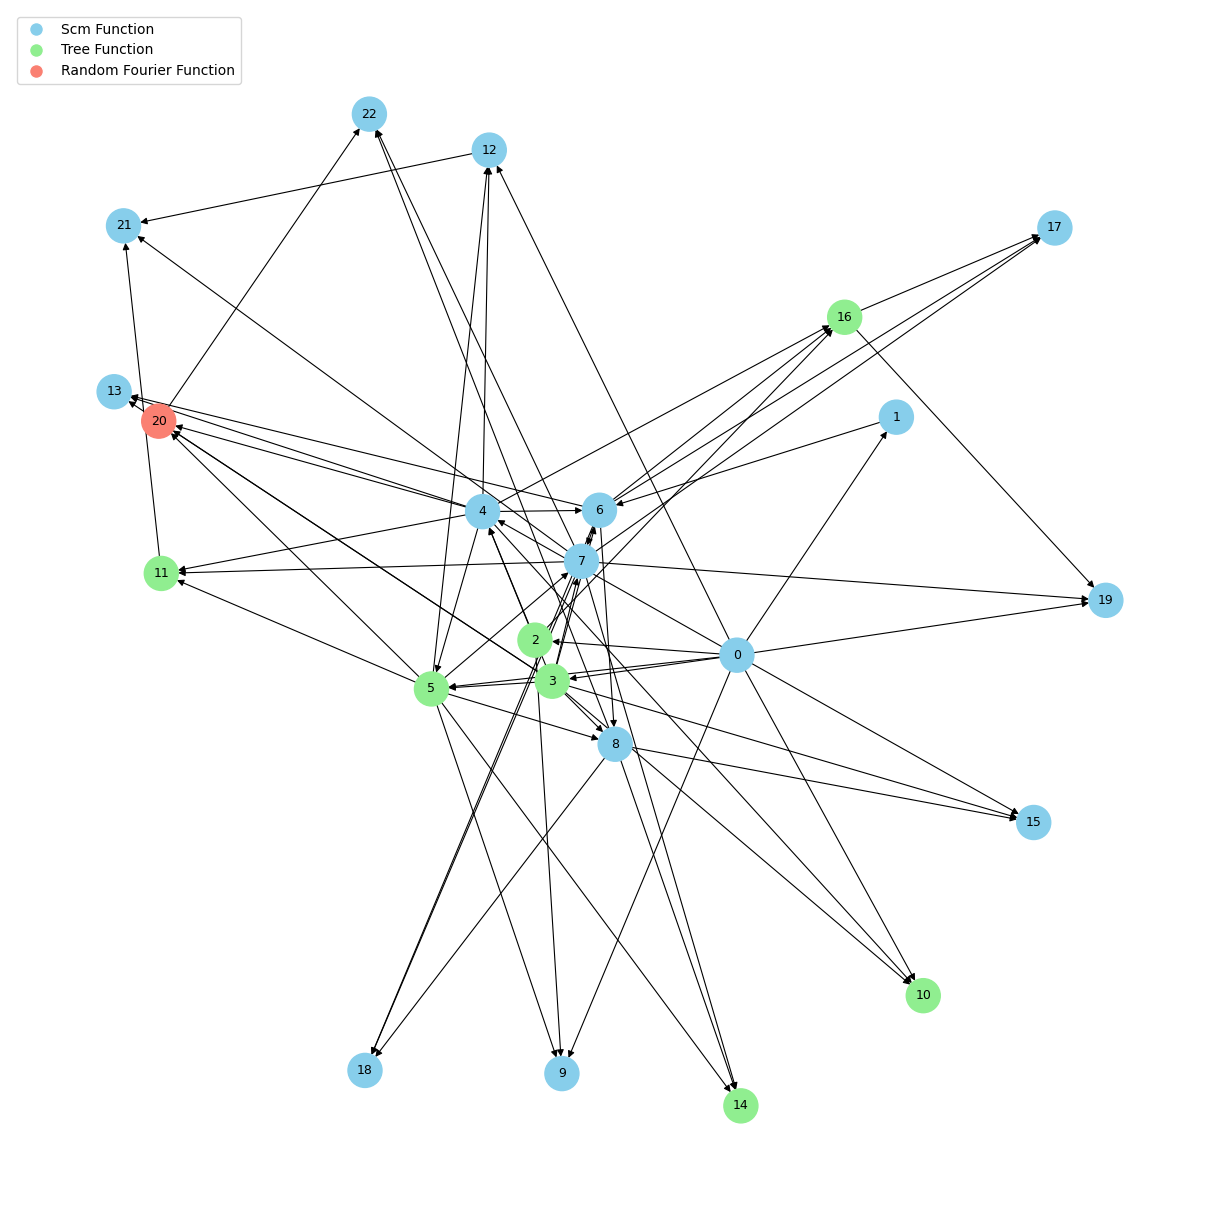

In [4]:
config = {
    'graph_generation_method': ['MLP-Dropout', 'Scale-Free'],
    'num_nodes_low': 20,
    'num_nodes_high': 50,
    'mlp_num_layers_mean': 5,
    'function_type_mixture_ratio': 0.7, # 70% SCMs or Random Fourier, 30% Tree-based
    'scm_activation_functions': list(ACTIVATION_FUNCTIONS.keys()),
    'xgb_n_estimators_exp_scale': 0.5,
    'xgb_max_depth_exp_scale': 0.5,
}

# --- Force generation of a Scale-Free DAG for this test ---
sf_test_config = config.copy()
sf_test_config['graph_generation_method'] = ['Scale-Free']
sf_test_dag = sample_dag_structure(sf_test_config)

assign_functional_mechanisms(sf_test_dag, config)


# --- verifying again ---
for node_id, data in sf_test_dag.nodes(data=True):
    mechanism_type = data.get('type')
    func_name = data.get('function_name')
    print(f"Node {node_id}: Type='{mechanism_type}', Function='{func_name}'")

types_assigned = {data.get('type') for _, data in sf_test_dag.nodes(data=True)}
print(f"\nmechanism types assigned to graph: {types_assigned}")


# --- Visualization ---
plt.figure(figsize=(12, 12))

pos = nx.spring_layout(sf_test_dag, seed=42, k=0.8)

color_map = {'scm': 'skyblue', 'tree': 'lightgreen', 'random_fourier': 'salmon'}
colors = [color_map.get(data.get('type', 'scm')) for _, data in sf_test_dag.nodes(data=True)]

nx.draw(sf_test_dag, pos, with_labels=True, node_size=600, node_color=colors, font_size=9, arrows=True, width=0.8)

legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=f'{mech_type.replace("_", " ").title()} Function',
                             markerfacecolor=color, markersize=10) for mech_type, color in color_map.items()]
plt.legend(handles=legend_handles, loc='upper left')

plt.show()

# Data Propagation and Matrix Generation

In [5]:
import pandas as pd

def generate_complete_matrix(config: dict) -> pd.DataFrame:
    """Generates a single, complete n x m matrix using the full SCM process."""
    dag = sample_dag_structure(config)
    assign_functional_mechanisms(dag, config)
    n_rows = int(sample_log_uniform(config['num_rows_low'], config['num_rows_high'])[0])
    sorted_nodes = list(nx.topological_sort(dag))
    node_data = {node: np.zeros(n_rows) for node in sorted_nodes}

    for node in sorted_nodes:
        parents = list(dag.predecessors(node))
        node_info = dag.nodes[node]
        if not parents:
            noise_type = np.random.choice(config['root_node_noise_dist'])
            if noise_type == 'Normal':
                node_data[node] = np.random.randn(n_rows)
            elif noise_type == 'Uniform':
                node_data[node] = np.random.uniform(-1, 1, n_rows)
        else:
            parent_values = np.vstack([node_data[p] for p in parents]).T
            if node_info['type'] == 'scm':
                linear_combination = np.dot(parent_values, node_info['weights']) + node_info['bias']
                node_data[node] = node_info['function'](linear_combination)
            elif node_info['type'] == 'random_fourier':
                selected_parent_data = parent_values[:, node_info['parent_selector']]
                node_data[node] = node_info['function'](selected_parent_data)
            elif node_info['type'] == 'tree':
                fake_targets = np.random.randn(n_rows)
                node_info['function'].fit(parent_values, fake_targets)
                node_data[node] = node_info['function'].predict(parent_values)

    num_scm_nodes = dag.number_of_nodes()
    m_cols = np.random.randint(config['num_cols_low'], min(num_scm_nodes + 1, config['num_cols_high']))
    final_cols = np.random.choice(list(node_data.keys()), m_cols, replace=False)
    matrix = pd.DataFrame({f"feature_{col}": node_data[col] for col in final_cols})

    if np.random.rand() < config['apply_feature_warping_prob']:
        print("Feature Warping with Beta Distribution")
        scaler = MinMaxScaler()
        for col in matrix.columns:
            # Scale data to [0, 1] range required by Beta
            col_data = scaler.fit_transform(matrix[[col]])

            # Sample shape parameters (alpha and beta) for the Beta
            a, b = np.random.rand() * 5 + 0.5, np.random.rand() * 5 + 0.5

            # Clip to avoid issues with 0 and 1
            epsilon = 1e-10
            clipped_data = np.clip(col_data, epsilon, 1 - epsilon)
            warped_data = beta.ppf(clipped_data, a, b)

            # Scale back to original range
            matrix[col] = scaler.inverse_transform(warped_data.reshape(-1, 1)).flatten()

    if np.random.rand() < config['apply_quantization_prob']:
        col_to_quantize = np.random.choice(matrix.columns)
        num_bins = np.random.randint(2, 20)
        try:
            matrix[col_to_quantize] = pd.qcut(matrix[col_to_quantize], q=num_bins, labels=False, duplicates='drop')
        except ValueError:
            pass # Ignore if quantization fails

    return matrix

In [6]:
config = {
    # Graph Structure
    'graph_generation_method': ['MLP-Dropout', 'Scale-Free'],
    'num_nodes_low': 20,
    'num_nodes_high': 100,
    'mlp_num_layers_mean': 6,

    # Functional Mechanisms
    'function_type_mixture_ratio': 0.7,
    'scm_activation_functions': list(ACTIVATION_FUNCTIONS.keys()),
    'xgb_n_estimators_exp_scale': 0.5,
    'xgb_max_depth_exp_scale': 0.5,

    # Data Generation
    'num_rows_low': 50,
    'num_rows_high': 1000,
    'num_cols_low': 5,
    'num_cols_high': 50,
    'root_node_noise_dist': ['Normal', 'Uniform'],

    # Post-processing
    'apply_feature_warping_prob': 0.1,
    'apply_quantization_prob': 0.1,
}

# Generate and Verify 1 Complete Matrix ---
final_matrix = generate_complete_matrix(config)

print(f"Final Matrix Shape: {final_matrix.shape}")
print("Data Types:\n", final_matrix.dtypes)
display(final_matrix.head())

# Check for obvs errors
assert not final_matrix.isnull().values.any(), "Matrix contains unexpected NaNs!"
assert final_matrix.shape[0] > 0 and final_matrix.shape[1] > 0, "Matrix is empty!"

Generating a 'Scale-Free' graph with 27 nodes...
Final Matrix Shape: (155, 23)
Data Types:
 feature_16    float64
feature_23    float32
feature_8     float64
feature_25    float64
feature_11    float32
feature_1     float64
feature_17    float64
feature_7     float64
feature_9     float64
feature_4     float32
feature_13    float64
feature_12    float64
feature_19    float64
feature_10    float64
feature_14    float32
feature_20    float64
feature_0     float64
feature_2     float64
feature_18    float64
feature_21    float32
feature_6     float64
feature_22    float64
feature_26    float32
dtype: object


,feature_16,feature_23,feature_8,feature_25,feature_11,feature_1,feature_17,feature_7,feature_9,feature_4,...,feature_10,feature_14,feature_20,feature_0,feature_2,feature_18,feature_21,feature_6,feature_22,feature_26
0,-1.153739,0.179843,1.071343,1.506664,0.038641,0.845718,0.706757,0.402746,1.0,0.010209,...,0.0,-0.14154,0.165994,-0.207665,5.259453,0.246565,-0.074779,-1.0,0.590481,0.245724
1,-1.153739,0.179300,1.704227,1.623437,0.131765,1.549357,0.706757,0.369198,1.0,0.010209,...,0.0,-0.14154,0.165994,-0.611420,3.660944,0.381948,-0.074779,-1.0,0.335785,-0.148169
2,-1.153739,-0.345540,2.269056,1.727653,-0.330478,2.177332,0.706757,0.340490,1.0,0.010209,...,0.0,-0.14154,0.165994,-0.971758,2.649510,-0.002901,-0.074779,-1.0,0.108476,0.089997
3,-1.153739,0.179843,1.014214,1.496124,0.038641,0.782202,0.706757,0.405846,1.0,0.010209,...,0.0,-0.14154,0.165994,-0.171219,5.434303,0.246565,-0.074779,-1.0,0.613472,0.075785
4,-1.153739,0.179843,0.907716,1.476474,0.038641,0.663799,0.706757,0.411657,1.0,0.010209,...,0.0,-0.14154,0.165994,-0.103278,5.775920,0.246565,-0.074779,-1.0,0.656331,0.075785


# Inducing Controlled Missingness on Matrices

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def _logit(x):
    """ need to convert log-odds to probs"""
    return 1 / (1 + np.exp(-x))

def induce_mcar(matrix: pd.DataFrame, p: float):
    mat = matrix.copy(); total_cells = mat.size; num_missing = int(total_cells * p)
    indices = np.random.choice(total_cells, num_missing, replace=False)
    row_indices, col_indices = np.unravel_index(indices, mat.shape)
    mat.values[row_indices, col_indices] = np.nan
    return mat

def induce_mar(matrix: pd.DataFrame, p: float):
    mat = matrix.copy(); num_cols = mat.shape[1]
    num_predictors = np.random.randint(1, max(2, num_cols // 2))
    predictor_cols = mat.sample(n=num_predictors, axis=1).columns
    target_cols = mat.columns.difference(predictor_cols)
    betas = np.random.randn(len(predictor_cols))
    log_odds = np.dot(mat[predictor_cols].fillna(0), betas)
    beta_0 = -np.quantile(log_odds, 1 - p)
    probs = _logit(log_odds + beta_0)
    for col in target_cols:
        mask = np.random.rand(len(mat)) < probs
        mat.loc[mask, col] = np.nan
    return mat

def induce_mnar(matrix: pd.DataFrame, p: float):
    mat = matrix.copy()
    target_cols = mat.sample(n=np.random.randint(1, mat.shape[1] + 1), axis=1).columns
    for col in target_cols:
        beta_1 = np.random.choice([-2, -1, 1, 2])
        log_odds = mat[col] * beta_1
        beta_0 = -np.quantile(log_odds, 1 - p) if not log_odds.isnull().all() else 0
        probs = _logit(log_odds + beta_0)
        mask = np.random.rand(len(mat)) < probs
        mat.loc[mask, col] = np.nan
    return mat

Target missingness: 0.30, Actual missingness: 0.30


,feature_0,feature_1,feature_2,feature_3,feature_4
0,0.496714,-0.138264,0.647689,NaN,-5.000000
1,NaN,1.579213,0.767435,-0.469474,-4.949749
2,NaN,-0.465730,0.241962,-1.913280,NaN
3,NaN,-1.012831,NaN,-0.908024,-4.849246
4,1.465649,-0.225776,NaN,-1.424748,-4.798995



---------------------------------------------
Target missingness: 0.30 (in target cols), Actual overall missingness: 0.30


,feature_0,feature_1,feature_2,feature_3,feature_4
0,NaN,NaN,NaN,1.523030,NaN
1,NaN,NaN,0.767435,-0.469474,-4.949749
2,-0.463418,NaN,0.241962,-1.913280,-4.899497
3,-0.562288,-1.012831,NaN,-0.908024,-4.849246
4,1.465649,NaN,0.067528,-1.424748,-4.798995



---------------------------------------------
Target missingness: 0.30 (in target cols), Actual overall missingness: 0.29


,feature_0,feature_1,feature_2,feature_3,feature_4
0,NaN,-0.138264,NaN,1.523030,NaN
1,NaN,NaN,0.767435,-0.469474,NaN
2,NaN,-0.465730,NaN,-1.913280,NaN
3,-0.562288,-1.012831,0.314247,-0.908024,NaN
4,1.465649,-0.225776,NaN,-1.424748,NaN


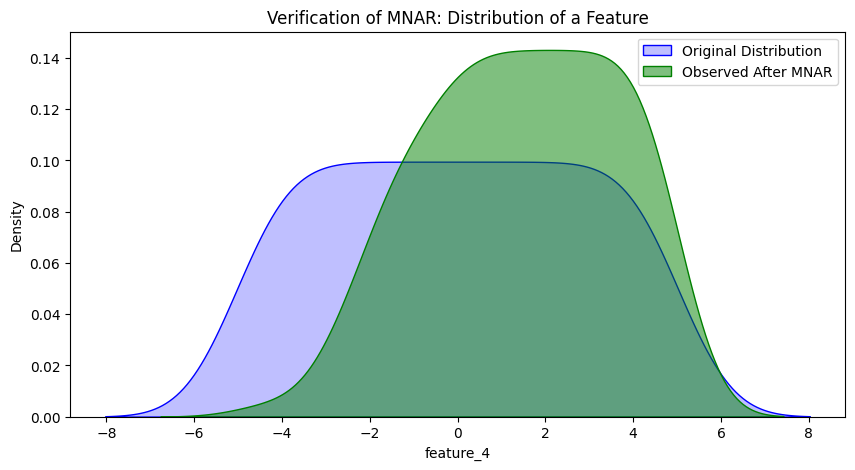

In [8]:
# --- Testing ---
# Create a sample complete DataFrame
np.random.seed(42)
complete_matrix = pd.DataFrame(
    np.random.randn(200, 5),
    columns=[f'feature_{i}' for i in range(5)]
)
# Add a feature with a clear trend for MNAR visualization
complete_matrix['feature_4'] = np.linspace(-5, 5, 200)

p_missing = 0.3  # Target 30% missingness

# --- Test MCAR ---
mcar_matrix = induce_mcar(complete_matrix, p=p_missing)
actual_p_mcar = mcar_matrix.isnull().sum().sum() / mcar_matrix.size
print(f"Target missingness: {p_missing:.2f}, Actual missingness: {actual_p_mcar:.2f}")
display(mcar_matrix.head())

# --- Test MAR ---
print("\n" + "---" * 15)
mar_matrix = induce_mar(complete_matrix, p=p_missing)
actual_p_mar = mar_matrix.isnull().sum().sum() / mar_matrix.size
print(f"Target missingness: {p_missing:.2f} (in target cols), Actual overall missingness: {actual_p_mar:.2f}")
display(mar_matrix.head())

# --- Test MNAR ---
print("\n" + "---" * 15)
mnar_matrix = induce_mnar(complete_matrix, p=p_missing)
actual_p_mnar = mnar_matrix.isnull().sum().sum() / mnar_matrix.size
print(f"Target missingness: {p_missing:.2f} (in target cols), Actual overall missingness: {actual_p_mnar:.2f}")
display(mnar_matrix.head())

# --- Verification Plot for MNAR ---
# missing values should concentrate at one end
plt.figure(figsize=(10, 5))
sns.kdeplot(complete_matrix['feature_4'], label='Original Distribution', color='blue', fill=True)
sns.kdeplot(mnar_matrix['feature_4'].dropna(), label='Observed After MNAR', color='green', fill=True, alpha=0.5)
plt.title("Verification of MNAR: Distribution of a Feature")
plt.legend()
plt.show()

#  "Cell-as-Sample" and Discretization

In [9]:
import pandas as pd
import numpy as np

def create_cell_as_sample_dataset(matrix: pd.DataFrame) -> pd.DataFrame:
    """
    Transforms incomplete matrix into supervised dataset. Each cell becomeess a data point with its features engineered from its
    position and the statistical context of its row+ column and the global matrix.
    """
    n_rows, m_cols = matrix.shape
    samples = []

    # Pre-calculate statistics on observed values to avoid re-computation
    # Pandas methods like .mean(), .std() etc. handle NaNs by default (they skip them)
    row_stats = {
        'mean': matrix.mean(axis=1),
        'std': matrix.std(axis=1),
        'min': matrix.min(axis=1),
        'max': matrix.max(axis=1),
        'count': matrix.count(axis=1) #s
    }
    col_stats = {
        'mean': matrix.mean(axis=0),
        'std': matrix.std(axis=0),
        'min': matrix.min(axis=0),
        'max': matrix.max(axis=0),
        'count': matrix.count(axis=0)
    }

    # For global stats, we work with entire set of observed values
    observed_values = matrix.values[~np.isnan(matrix.values)]
    global_mean = observed_values.mean()
    global_std = observed_values.std()
    global_count = len(observed_values)

    for i in range(n_rows):
        for j in range(m_cols):
            feature_vector = {}

            # 1. Positional Features
            feature_vector['row_idx'] = i
            feature_vector['col_idx'] = j

            # 2. Contextual Features
            # Row-wise stats
            feature_vector['row_mean'] = row_stats['mean'].iloc[i]
            feature_vector['row_std'] = row_stats['std'].iloc[i]
            feature_vector['row_min'] = row_stats['min'].iloc[i]
            feature_vector['row_max'] = row_stats['max'].iloc[i]
            feature_vector['row_count_observed'] = row_stats['count'].iloc[i]

            # Column-wise stats
            feature_vector['col_mean'] = col_stats['mean'].iloc[j]
            feature_vector['col_std'] = col_stats['std'].iloc[j]
            feature_vector['col_min'] = col_stats['min'].iloc[j]
            feature_vector['col_max'] = col_stats['max'].iloc[j]
            feature_vector['col_count_observed'] = col_stats['count'].iloc[j]

            # Global stats
            feature_vector['global_mean'] = global_mean
            feature_vector['global_std'] = global_std
            feature_vector['global_count_observed'] = global_count

            # Targetvar (cell's actual value, can be nan)
            feature_vector['target_value'] = matrix.iloc[i, j]

            samples.append(feature_vector)

    return pd.DataFrame(samples)

In [10]:
# --- test test testing ---
# Create a small, incomplete sample matrix for easy verification
data = {
    'col_A': [1.0, 4.0, 7.0, np.nan],
    'col_B': [2.0, np.nan, 8.0, 11.0],
    'col_C': [3.0, 6.0, 9.0, 12.0]
}
incomplete_matrix = pd.DataFrame(data)

display(incomplete_matrix)


# --- Transform mat ---
cell_dataset = create_cell_as_sample_dataset(incomplete_matrix)


# --- Verifying ---
print(f"Original shape: {incomplete_matrix.shape}")
print(f"New shape: {cell_dataset.shape}")
print(f"Verification: {incomplete_matrix.size} total cells == {cell_dataset.shape[0]} rows -> {incomplete_matrix.size == cell_dataset.shape[0]}")

display(cell_dataset)

# --- Verifying cell ---
print("\n--- Manual Verification for Cell (0, 0) ---")

row_0_mean = np.mean([1, 2, 3])
col_A_mean = np.mean([1, 4, 7])

cell_0_0_features = cell_dataset.iloc[0]

print(f"Calculated Row 0 Mean: {row_0_mean:.4f}")
print(f"Feature 'row_mean' in dataset for cell (0,0): {cell_0_0_features['row_mean']:.4f}\n")

print(f"Calculated Col 'A' Mean: {col_A_mean:.4f}")
print(f"Feature 'col_mean' in dataset for cell (0,0): {cell_0_0_features['col_mean']:.4f}\n")

print("double check the target for a missing cell like (1,1)")
cell_1_1_features = cell_dataset.iloc[4] # (1*3_cols + 1) = 4th row
print(f"Target value for cell (1,1): {cell_1_1_features['target_value']}")
assert np.isnan(cell_1_1_features['target_value'])


,col_A,col_B,col_C
0,1.0,2.0,3.0
1,4.0,NaN,6.0
2,7.0,8.0,9.0
3,NaN,11.0,12.0


Original shape: (4, 3)
New shape: (12, 16)
Verification: 12 total cells == 12 rows -> True


,row_idx,col_idx,row_mean,row_std,row_min,row_max,row_count_observed,col_mean,col_std,col_min,col_max,col_count_observed,global_mean,global_std,global_count_observed,target_value
0,0,0,2.0,1.000000,1.0,3.0,3,4.0,3.000000,1.0,7.0,3,6.3,3.579106,10,1.0
1,0,1,2.0,1.000000,1.0,3.0,3,7.0,4.582576,2.0,11.0,3,6.3,3.579106,10,2.0
2,0,2,2.0,1.000000,1.0,3.0,3,7.5,3.872983,3.0,12.0,4,6.3,3.579106,10,3.0
3,1,0,5.0,1.414214,4.0,6.0,2,4.0,3.000000,1.0,7.0,3,6.3,3.579106,10,4.0
4,1,1,5.0,1.414214,4.0,6.0,2,7.0,4.582576,2.0,11.0,3,6.3,3.579106,10,NaN
5,1,2,5.0,1.414214,4.0,6.0,2,7.5,3.872983,3.0,12.0,4,6.3,3.579106,10,6.0
6,2,0,8.0,1.000000,7.0,9.0,3,4.0,3.000000,1.0,7.0,3,6.3,3.579106,10,7.0
7,2,1,8.0,1.000000,7.0,9.0,3,7.0,4.582576,2.0,11.0,3,6.3,3.579106,10,8.0
8,2,2,8.0,1.000000,7.0,9.0,3,7.5,3.872983,3.0,12.0,4,6.3,3.579106,10,9.0
9,3,0,11.5,0.707107,11.0,12.0,2,4.0,3.000000,1.0,7.0,3,6.3,3.579106,10,NaN



--- Manual Verification for Cell (0, 0) ---
Calculated Row 0 Mean: 2.0000
Feature 'row_mean' in dataset for cell (0,0): 2.0000

Calculated Col 'A' Mean: 4.0000
Feature 'col_mean' in dataset for cell (0,0): 4.0000

double check the target for a missing cell like (1,1)
Target value for cell (1,1): nan


In [11]:
import pandas as pd
import numpy as np

def discretize_target(df: pd.DataFrame, target_col: str, num_bins: int) -> pd.DataFrame:
    """
    Discretizes a continuous target column into a specified number of bins.
    """
    df_copy = df.copy()
    binned_col_name = f"{target_col}_binned"

    # Use qcut for quantile-based binning
    df_copy[binned_col_name] = pd.qcut(
        df_copy[target_col],
        q=num_bins,
        labels=False,
        duplicates='drop'
    )

    return df_copy

In [12]:
np.random.seed(42)

n_rows = 100
n_nans = 5
n_values = n_rows - n_nans

target_values = list(np.linspace(0, 100, n_values)) + [np.nan] * n_nans
np.random.shuffle(target_values)

data = {
    'row_idx': list(range(n_rows)),
    'col_idx': [0] * n_rows,
    'target_value': target_values
}
sample_cell_dataset = pd.DataFrame(data)


print("--- Original DataFrame (Partial View) ---")
display(sample_cell_dataset.head(10))
print(f"Number of NaNs in original target: {sample_cell_dataset['target_value'].isnull().sum()}")


# --- Apply  Discretize ---
num_bins_to_create = 10
discretized_dataset = discretize_target(
    df=sample_cell_dataset,
    target_col='target_value',
    num_bins=num_bins_to_create
)

display(discretized_dataset.head(10))


# ---verkify
binned_col = 'target_value_binned'
print(f"Data type of new column '{binned_col}': {discretized_dataset[binned_col].dtype}")

# Check NaN values are preserved
original_nans = sample_cell_dataset['target_value'].isnull().sum()
new_nans = discretized_dataset[binned_col].isnull().sum()
print(f"Original NaNs: {original_nans}, Preserved NaNs: {new_nans} -> Correct: {original_nans == new_nans}")

# Verify distribution of values into bins
print(discretized_dataset[binned_col].value_counts().sort_index())

--- Original DataFrame (Partial View) ---


,row_idx,col_idx,target_value
0,0,0,88.297872
1,1,0,56.382979
2,2,0,74.468085
3,3,0,47.872340
4,4,0,46.808511
5,5,0,41.489362
6,6,0,23.404255
7,7,0,85.106383
8,8,0,10.638298
9,9,0,0.000000


Number of NaNs in original target: 5


,row_idx,col_idx,target_value,target_value_binned
0,0,0,88.297872,8.0
1,1,0,56.382979,5.0
2,2,0,74.468085,7.0
3,3,0,47.872340,4.0
4,4,0,46.808511,4.0
5,5,0,41.489362,4.0
6,6,0,23.404255,2.0
7,7,0,85.106383,8.0
8,8,0,10.638298,1.0
9,9,0,0.000000,0.0


Data type of new column 'target_value_binned': float64
Original NaNs: 5, Preserved NaNs: 5 -> Correct: True
target_value_binned
0.0    10
1.0     9
2.0    10
3.0     9
4.0    10
5.0     9
6.0     9
7.0    10
8.0     9
9.0    10
Name: count, dtype: int64


#Data generation and pre train pipeline